# Locality-Sensitive Hashing for Approximate Nearest Neighbour

Implementation of LSH for approximate nearest neighbour search.

## Setup

In [ ]:
import numpy as np
import random
import time
import unittest
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import defaultdict
from matplotlib import pyplot as plt

## LSH Implementation

In [ ]:
def l1(u, v):
    """
    Finds the L1 distance between two vectors
    u and v are 1-dimensional np.array objects
    """
    return np.sum(np.abs(u - v))

    # raise NotImplementedError

In [ ]:
class my_LSH:
    def __init__(self, dataset, n_bands, n_rows):
        """
        Initializes the LSH object
        dataset - dataset to be searched
        n_bands - number of bands
        n_rows - number of rows in each band
        """
        self.n_bands =  n_bands
        self.n_rows =  n_rows

        self.A  =  dataset
        self.bands  =  self.create_bands()
        self.bands_buckets = [defaultdict(set) for band in self.bands]
        self.index_data()

    def create_band_function(self, dimensions, thresholds):
        """
        Creates a g_j function from the original image and compare from a list of dimensions and thresholds.
        Each g_j function generates the j'th band values for a given datapoint (a concatenation of r hash values).
        Each (locality-sensitive) hash value is equal 1 if the corresponding dimension in the original image is higher than the corresppnding threshold.
        """
        def band_function(v):
            boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
            return "".join(map(str, map(int, boolarray)))
        return band_function

    def create_bands(self, num_dimensions=400, min_threshold=0, max_threshold=255):
        """
        Creates the collection of g_j functions 1<=j<=b, one for each band.
        Each function selects r dimensions (i.e. column indices of the image matrix)
        at random, and then chooses a random threshold for each dimension, between 0 and
        255.  For any image, if its value on a given dimension is greater than or equal to
        the randomly chosen threshold, we set that bit to 1.  Each hash function returns
        a length-r bit string of the form "0101010001101001...".
        """
        bands = []
        for i in range(self.n_bands):
            dimensions = np.random.randint(low = 0,
                                        high = num_dimensions,
                                        size = self.n_rows)
            thresholds = np.random.randint(low = min_threshold,
                                        high = max_threshold + 1,
                                        size = self.n_rows)

            bands.append(self.create_band_function(dimensions, thresholds))
        return bands

    def hash_vector(self, v):
        """
        Hashes an individual vector (i.e. image).  This produces an array with b
        entries (one for each band), where each entry is a string of r bits (one for each row).
        """
        return [f(v) for f in self.bands]

    def index_data(self):
        """
        Hashes the data in A, where each row is a datapoint, using the b band
        functions in "functions." For each band, we use the corresponding dictionary (hash table) to index the data point.
        """
        for doc_index in range(self.A.shape[0]):
            doc_hash = self.hash_vector(self.A[doc_index,:])
            for band_idx, doc_band_hash in enumerate(doc_hash):
                self.bands_buckets[band_idx][doc_band_hash].add(doc_index)

    def get_candidates(self, query_vector):
        """
        Retrieve all of the points that hash to one of the same buckets as the query point.
        """
        query_hash = self.hash_vector(query_vector)
        candidates = set()
        for band_idx, query_band_hash in enumerate(query_hash):
          bucket_candidates = self.bands_buckets[band_idx][query_band_hash]
          candidates = candidates.union(bucket_candidates)
        return candidates

    def lsh_search(self, query_vector , num_neighbours=10):
        """
        Run the entire LSH algorithm
        """
        # 1. Get the candidates for nearest neighbours
        candidates = self.get_candidates(query_vector)

        # 2. Determine distance of candidates
        distances = [(l1(query_vector, self.A[candidate]), candidate) for candidate in candidates]
        distances.sort()

        # 3. Extract best neighbours
        best_neighbours = distances[:num_neighbours]
        lsh_neighbours = [neighbour[1] for neighbour in best_neighbours]
        lsh_dist = [neighbour[0] for neighbour in best_neighbours]

        # 4. Return a list of the best neighbours and a list of the corresponding distances between each neighbour and the query
        return lsh_neighbours, lsh_dist

In [ ]:
def plot(A, row_nums, base_filename):
    """
    Plots images at the specified rows and saves them each to files.
    """
    plt.figure(figsize=(15, 15))
    for i, row_num in enumerate(row_nums):
        plt.subplot(1, 10, i+1)
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        plt.axis('off')
        plt.imshow(im)
        im.save(base_filename + "-" + str(row_num) + ".png")

In [ ]:
#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(lsh.hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(lsh.hash_data(functions, A), np.array([[6, 14], [15, 77]])))

## Data

In [ ]:
#!unzip patches.csv.zip

Split data with 100 random query points

In [ ]:
data = np.genfromtxt('patches.csv', delimiter=',')
dataset, query_points = train_test_split(data, test_size=100, random_state=42)

## Experiments

### Compare LSH and linear search runtimes

In [ ]:
# Initialize a my_LSH class
lsh = my_LSH(dataset , n_rows=24 , n_bands=10 )

In [ ]:
test = TestLSH( )
test.test_l1( )

In [ ]:
def linear_search(A, query_vector, num_neighbours):
    """
    Finds the nearest neighbours to a given vector, using linear search.
    """
    # Determine distance between query vector and every vector in A
    distances = [(l1(query_vector, A[candidate]), candidate) for candidate in range(len(A))]
    distances.sort()

    # Extract best neighbours
    best_neighbours = distances[:num_neighbours]
    lsh_neighbours = [neighbour[1] for neighbour in best_neighbours]
    lsh_dist = [neighbour[0] for neighbour in best_neighbours]

    return lsh_neighbours, lsh_dist

    # raise NotImplementedError

In [ ]:
# Using LSH to find top 3 near neighbours
lsh_times = []
for query_point in query_points:
    lsh_start = time.time()
    lsh_neighbours, lsh_dist = lsh.lsh_search(query_point, num_neighbours=3)
    lsh_end = time.time()
    lsh_times.append(lsh_end - lsh_start)
print(f"Average LSH time: {np.mean(lsh_times)} seconds")

# Using linear search to find top 3 near neighbours
linear_search_times = []
for query_point in query_points:
    linear_search_start = time.time()
    linear_search_neighbours, linear_search_dist = linear_search(dataset, query_point, num_neighbours=3)
    linear_search_end = time.time()
    linear_search_times.append(linear_search_end - linear_search_start)
print(f"Average Linear Search time: {np.mean(linear_search_times)} seconds")

Average LSH time: 0.03426547050476074 seconds
Average Linear Search time: 0.5563075113296508 seconds


### Effects of changing b and r on the error

In [ ]:
def lsh_error( lsh_dist, linear_dist ):
    """
    Computes the error measure

    If there are less than 3 neighbours, we just compute on the top k for 0<k<3.
    If there are no neighbours, we will skip them in the calculation.
    """
    error = 0
    count = 0

    for i in range(len(linear_dist)):
        k = len(lsh_dist[i])
        if k > 0:
            error += np.sum(lsh_dist[i][:k]) / np.sum(linear_dist[i][:k])
            count += 1

    return error / count

    # raise NotImplementedError

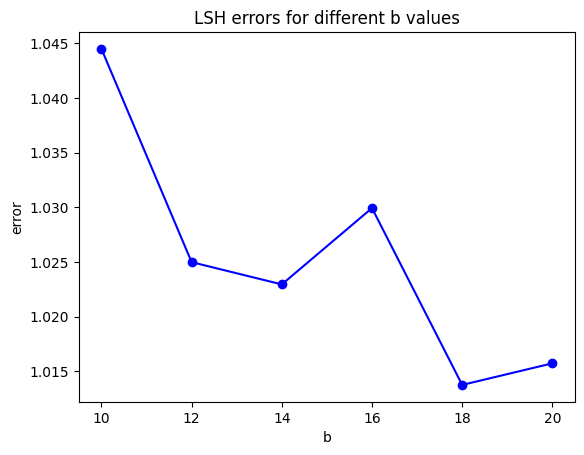

In [ ]:
# Plot error value as a function of b
b = [i for i in range(10, 22, 2)]
r = 24
num_query_points = len(query_points)
errors = []

linear_search_distances = []
for query_point in query_points:
    linear_search_neighbours, linear_search_dist = linear_search(dataset, query_point, num_neighbours=3)
    linear_search_distances.append(linear_search_dist)

for b_val in b:
    lsh = my_LSH(dataset, n_rows=r, n_bands=b_val)
    lsh_distances = []
    for i in range(num_query_points):
        lsh_neighbours, lsh_dist = lsh.lsh_search(query_points[i], num_neighbours=3)
        lsh_distances.append(lsh_dist)
    errors.append(lsh_error(lsh_distances, linear_search_distances))

plt.plot(b, errors, 'bo-')
plt.xlabel("b")
plt.ylabel("error")
plt.title("LSH errors for different b values")
plt.show()

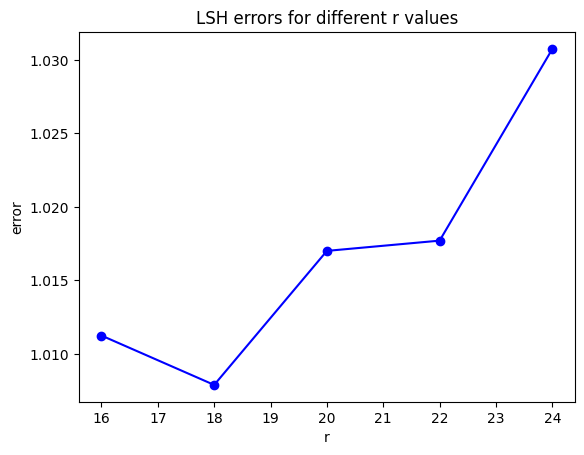

In [ ]:
# Plot error value as a function of r
r = [i for i in range(16, 26, 2)]
b = 10
num_query_points = len(query_points)
errors = []

linear_search_distances = []
for query_point in query_points:
    linear_search_neighbours, linear_search_dist = linear_search(dataset, query_point, num_neighbours=3)
    linear_search_distances.append(linear_search_dist)

for r_val in r:
    lsh = my_LSH(dataset, n_rows=r_val, n_bands=b)
    lsh_distances = []
    for i in range(num_query_points):
        lsh_neighbours, lsh_dist = lsh.lsh_search(query_points[i], num_neighbours=3)
        lsh_distances.append(lsh_dist)
    errors.append(lsh_error(lsh_distances, linear_search_distances))

plt.plot(r, errors, 'bo-')
plt.xlabel("r")
plt.ylabel("error")
plt.title("LSH errors for different r values")
plt.show()

For the plot of the error value as a function of b, we can see that it generally shows decreasing error values when b increases. This is expected because as we increase the number of bands, there would be a greater chance for two similar items to be hashed together, which would decrease the number of false negatives and lead to more accurate nearest neighbour results and lower error values.

For the plot of the error value as a function of r, we can see that it generally shows increasing error values when r increases. This is expected because as we increase the number of rows per band, there would be less chance for two similar items to be hashed together, which would increase the number of false negatives and lead to less accurate nearest neighbour results and higher error values.

### Compare plots of top 10 nearest neighbours from LSH and linear search

In [ ]:
# Using LSH to find top 10 near neighbours
lsh = my_LSH(dataset, n_rows=24 , n_bands=10)
lsh_neighbours, lsh_dist = lsh.lsh_search(query_points[99], num_neighbours=10)

# Using linear search to find top 10 near neighbours
linear_search_neighbours, linear_search_dist = linear_search(dataset, query_points[99], num_neighbours=10)

Query Point


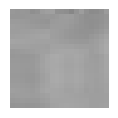

In [ ]:
print("Query Point")
plot(query_points, [99], "query_points")

Top 10 nearest neighbours using LSH


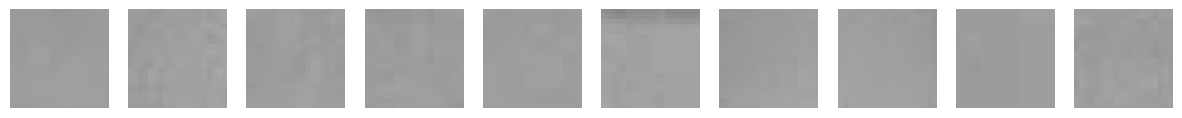

In [ ]:
print("Top 10 nearest neighbours using LSH")
plot(dataset, lsh_neighbours, "lsh_neighbours")

Top 10 nearest neighbours using Linear Search


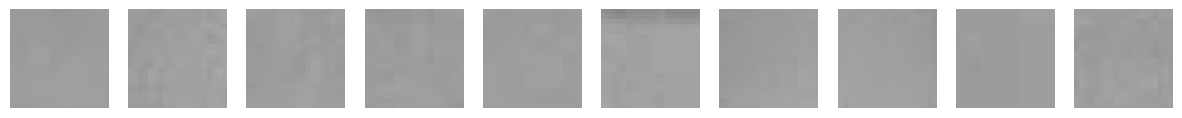

In [ ]:
print("Top 10 nearest neighbours using Linear Search")
plot(dataset, linear_search_neighbours, "linear_search_neighbours")

Both the LSH and linear search produced the same top 10 nearest neighbour results. Compared to the query point image patch that we used, they look pretty similar (ie. they all look pretty uniform with roughly the same brightness throughout and the brighter areas are all roughly in the same parts of the patch and the darker areas are also roughly in the same parts of the patch).